# Fine tuning BERT for information retrieval using Amazon Sagemaker 

## Install and import dependencies

In [1]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-q", "-m", "pip", "install", package])
    
install('sentence_transformers')
install('opensearch-py')
install('requests_aws4auth')

import json
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, LoggingHandler, util, models, evaluation, losses, InputExample
import logging
from datetime import datetime
import gzip
import os
import tarfile
from collections import defaultdict
from torch.utils.data import IterableDataset
import tqdm
from torch.utils.data import Dataset
import random
import pickle
import argparse
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

## Setup the Sagemaker session, region and the role 

In [2]:
import boto3
sess = sagemaker.Session()
role = get_execution_role()
boto3_session = boto3.session.Session()
my_region = boto3_session.region_name
output_path = "s3://" + sess.default_bucket() + "/nlp-dualencoder"

## Sample Training input instance

## Train the Bi-Encoder

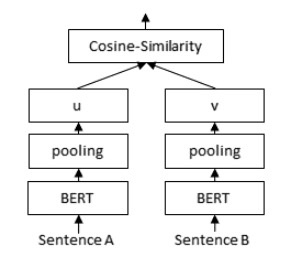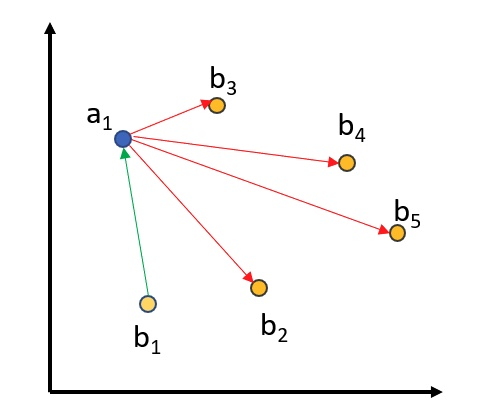

#### References: https://www.sbert.net/examples/training/ms_marco/README.html

In [6]:
local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c5.4xlarge"

est = PyTorch(
    entry_point="nlp_loader_test.py",
    source_dir="/home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/scripts/code",  # directory of your training script
    role=role,
    framework_version="1.5.0",
    py_version="py3",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    #hyperparameters={"batch-size": 128, "epochs": 1, "learning-rate": 1e-3, "log-interval": 100},
)

est.fit()

2022-09-22 17:59:47 Starting - Starting the training job...ProfilerReport-1663869586: InProgress
...
2022-09-22 18:00:30 Starting - Preparing the instances for training......
2022-09-22 18:01:47 Downloading - Downloading input data
2022-09-22 18:01:47 Training - Downloading the training image......
2022-09-22 18:02:33 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-22 18:02:35,154 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-22 18:02:35,168 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 18:02:35,177 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-22 18:02:35,183 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-22 18:02:35,528 sagemaker-training-toolkit INFO     No G

###### Use one (non-gpu) from below for the instance_type

[ml.trn1.32xlarge, ml.p2.xlarge, ml.m5.4xlarge, ml.m4.16xlarge, ml.p4d.24xlarge, ml.g5.2xlarge, ml.c5n.xlarge, ml.p3.16xlarge, ml.m5.large, ml.p2.16xlarge, ml.g5.4xlarge, ml.c4.2xlarge, ml.c5.2xlarge, ml.c4.4xlarge, ml.g5.8xlarge, ml.c5.4xlarge, ml.c5n.18xlarge, ml.g4dn.xlarge, ml.g4dn.12xlarge, ml.c4.8xlarge, ml.g4dn.2xlarge, ml.c5.9xlarge, ml.g4dn.4xlarge, ml.c5.xlarge, ml.g4dn.16xlarge, ml.c4.xlarge, ml.g4dn.8xlarge, ml.g5.xlarge, ml.c5n.2xlarge, ml.g5.12xlarge, ml.g5.24xlarge, ml.c5n.4xlarge, ml.trn1.2xlarge, ml.c5.18xlarge, ml.p3dn.24xlarge, ml.g5.48xlarge, ml.g5.16xlarge, ml.p3.2xlarge, ml.m5.xlarge, ml.m4.10xlarge, ml.c5n.9xlarge, ml.m5.12xlarge, ml.m4.xlarge, ml.m5.24xlarge, ml.m4.2xlarge, ml.p2.8xlarge, ml.m5.2xlarge, ml.p3.8xlarge, ml.m4.4xlarge]

## Get the latest trained model

In [7]:
import boto3
bucket = sess.default_bucket()
#Make sure you provide / in the end
prefix = 'nlp-dualencoder/' 
key_list=[]

s3_client = boto3.client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')
for i in result.get('CommonPrefixes'):
    key_list.append(i.get('Prefix'))
    
key_list_sorted = sorted(key_list, reverse=True)
model_artifact_s3uri = 's3://'+bucket+'/'+key_list_sorted[0]+'output/model.tar.gz'
model_artifact_s3key = key_list_sorted[0]+'output/model.tar.gz'
model_artifact_s3key_prefix = key_list_sorted[0].split("/")[0]
model_artifact_s3uri

's3://sagemaker-us-east-1-530175556550/nlp-dualencoder/pytorch-training-2022-09-22-17-59-46-575/output/model.tar.gz'

## Model Inference

In [9]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
entry_point = 'inference.py',
    source_dir="/home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/scripts/code",
   model_data=model_artifact_s3uri,       # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17.0",  # transformers version used
   pytorch_version="1.10.2",        # pytorch version used
   py_version='py38',            # python version used
)



## Realtime endpoint for queries

In [10]:
# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge"
    )
query_vector = predictor.predict({
	'inputs': "The answer to the universe is GOD."
})
query_vector['vectors'][0]

-----!

[0.20672118663787842,
 -0.43249380588531494,
 -0.24907320737838745,
 -0.7850667238235474,
 0.609385073184967,
 0.139979749917984,
 0.21420805156230927,
 0.6717072129249573,
 0.7164131999015808,
 0.3544222414493561,
 0.2206510305404663,
 0.7141620516777039,
 0.29206353425979614,
 -0.13417957723140717,
 -0.2950604259967804,
 -0.07825774699449539,
 -0.20243409276008606,
 0.45214352011680603,
 -0.297286719083786,
 -0.3742522895336151,
 -0.04223030060529709,
 -0.7407914996147156,
 -0.34297114610671997,
 -0.3239707946777344,
 -0.31813108921051025,
 -0.4158659875392914,
 0.45003384351730347,
 -0.1739802062511444,
 -0.03814905509352684,
 0.1477469950914383,
 -0.7191972732543945,
 -0.1698092371225357,
 0.18922916054725647,
 0.30199360847473145,
 -0.277452290058136,
 -0.19184522330760956,
 -0.6481972932815552,
 0.13993114233016968,
 -0.6416659951210022,
 -0.5250850319862366,
 -0.10226984322071075,
 -0.6798254251480103,
 -0.7216775417327881,
 0.35611072182655334,
 -0.3308749496936798,
 0.01472926

## Copy model extracts to local

In [11]:
s3_client.download_file(bucket, model_artifact_s3key, '/home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/model.tar.gz')
!rm -rf ./trained_bert_model_extract
!mkdir ./trained_bert_model_extract
!tar -xvzf /home/ec2-user/SageMaker/amazon-sagemaker-bert-finetuning-for-search/model.tar.gz -C ./trained_bert_model_extract

config_sentence_transformers.json
tokenizer_config.json
sentence_bert_config.json
pytorch_model.bin
vocab.txt
tokenizer.json
special_tokens_map.json
README.md
config.json
1_Pooling/
1_Pooling/config.json
modules.json


## Batch Transform the docs to vectors

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel
import torch
import torch.nn.functional as F
import os

from itertools import islice
import math
import pandas as pd
from numpy.random import randint


def take_(n, iterable):
    "Return first n items of the iterable as a list"
    return dict(islice(iterable, n))


model_data='./trained_bert_model_extract'

dataframe_list=[]
cols = ['docs','bert_encoded_doc_vectors']

tokenizer = AutoTokenizer.from_pretrained(model_data)
model = BertModel.from_pretrained(model_data)

### Now we read the MS Marco dataset
data_folder = 'msmarco-data'

#### Read the corpus files, that contain all the passages. Store them in the corpus dict
corpus = {}         #dict in the format: passage_id -> passage. Stores all existent passages
collection_filepath = os.path.join(data_folder, 'collection.tsv')
if not os.path.exists(collection_filepath):
    tar_filepath = os.path.join(data_folder, 'collection.tar.gz')
    if not os.path.exists(tar_filepath):
        logging.info("Download collection.tar.gz")
        util.http_get('https://msmarco.blob.core.windows.net/msmarcoranking/collection.tar.gz', tar_filepath)

    with tarfile.open(tar_filepath, "r:gz") as tar:
        tar.extractall(path=data_folder)

logging.info("Read corpus: collection.tsv")
with open(collection_filepath, 'r', encoding='utf8') as fIn:
    for line in fIn:
        pid, passage = line.strip().split("\t")
        pid = int(pid)
        corpus[pid] = passage

n_items = take_(2, corpus.items())


for key in n_items.items():

    tmp_list=[]
    encoded_input = tokenizer(n_items[key[0]], padding=True, truncation=True, return_tensors='pt')["input_ids"]
    bert_encoded = model(encoded_input)["pooler_output"].tolist()
    tmp_list.append(n_items[key[0]])
    tmp_list.append(bert_encoded[0])
    dataframe_list.append(tmp_list)
transformed_dataframe = pd.DataFrame(dataframe_list, columns=cols)

transformed_dataframe.to_csv('./transfromed_vectors.csv',index=False)

s3_client.upload_file('./transfromed_vectors.csv',bucket,  model_artifact_s3key_prefix+'/batch_output/transfromed_vectors.csv')



You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at ./trained_bert_model_extract were not used when initializing BertModel: ['transformer.layer.3.attention.q_lin.weight', 'transformer.layer.4.attention.v_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.2.attention.q_lin.bias', 'transformer.layer.3.attention.v_lin.weight', 'transformer.layer.4.attention.q_lin.bias', 'transformer.layer.4.sa_layer_norm.weight', 'transformer.layer.5.ffn.lin2.bias', 'transformer.layer.4.attention.k_lin.bias', 'transformer.layer.5.attention.v_lin.bias', 'transformer.layer.3.attention.k_lin.weight', 'transformer.layer.2.sa_layer_norm.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.2.attention.out_lin.weight', 'transformer.layer.5.attention.q_lin.bias', 'transformer.layer.5.attention.out_lin.weight', 'transformer.layer.

  0%|          | 0.00/1.04G [00:00<?, ?B/s]

## Get the domain endpoint from the cloudformation outputs

In [13]:
cfn_client = boto3.client('cloudformation')

paginator = cfn_client.get_paginator('describe_stacks')

response_iterator = paginator.paginate(
    StackName='static-cfn',
    PaginationConfig={
        'MaxItems': 123,
        'StartingToken': 'string'
    }
)
response_iterator

for i in response_iterator:
    for j in i['Stacks'][0]['Outputs']:
        if(j['OutputKey']=='DomainEndpoint'):
            host = j['OutputValue']
            break

## OpenSearch domain

In [14]:
import sagemaker
import boto3

sts_client = boto3.client('sts')

# Call the assume_role method of the STSConnection object and pass the role
# ARN and a role session name.

assumed_role_object=sts_client.assume_role(
    RoleArn=role,
    RoleSessionName="AssumeRoleSession1"
)

# From the response that contains the assumed role, get the temporary 
# credentials that can be used to make subsequent API calls

credentials=assumed_role_object['Credentials']


session = boto3.Session(
    aws_access_key_id=credentials['AccessKeyId'],
    aws_secret_access_key=credentials['SecretAccessKey'],
    aws_session_token=credentials['SessionToken']
)

credentials = session.get_credentials()

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import boto3


port = 443

s3 = boto3.client('s3')
import re
import requests
import json

from requests_aws4auth import AWS4Auth
endpoint = 'https://'+host # the proxy endpoint, including https://
region = my_region
service = 'execute-api'

awsauth = AWSV4SignerAuth(credentials, region)

headers = { "Content-Type": "application/json"
}



client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    #verify_certs = True,
    connection_class = RequestsHttpConnection
)

client



/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


<OpenSearch([{'host': 'vpc-semantic-search-xs7idnyp5rysanoqxt4q7xgfzu.us-east-1.es.amazonaws.com', 'port': 443}])>

## create index and mapping

In [15]:
index_name = 'nlpindex_search_bert'
index_body = {
  'settings': {
    'index': {
      'number_of_shards': 4,
        'knn': True
    }
  },

    'mappings': {
       
            'properties': {
                'passage': {'type': 'text'},
                
               "bert_vector": {
        "type": "knn_vector",
        "dimension": 768
      },
            }}
}


response = client.indices.create(index_name, body=index_body)
print('\nCreating index:')
print(response)




Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'nlpindex_search_bert'}


## Index the document and vectors (Batch Transform)

In [16]:
import pandas as pd
import s3fs
from ast import literal_eval

df = pd.read_csv('s3://'+bucket+'/'+model_artifact_s3key_prefix+'/batch_output/transfromed_vectors.csv')
df

df = df.reset_index()  # make sure indexes pair with number of rows

for index, row in df.iterrows():
    line={}
    line['passage']=row['docs']
    line['bert_vector']=literal_eval(row['bert_encoded_doc_vectors'])

    response = client.index(
    index = index_name,
    body = line)
    print(response)

{'_index': 'nlpindex_search_bert', '_type': '_doc', '_id': '1_x0ZoMBT7uJWy_4rE2q', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1}
{'_index': 'nlpindex_search_bert', '_type': '_doc', '_id': '2Px0ZoMBT7uJWy_4rE3p', '_version': 1, 'result': 'created', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1}


## Search the domain in realtime using sagemaker endpoint and lambda

In [17]:
query_vector = predictor.predict({
	'inputs': "The answer to the universe is GOD."
})

q = 'miller'
query = {"query":{
  "knn": {
      "bert_vector": {
        "vector": query_vector['vectors'][0],
        "k": 1
      }
    }
}}


response = client.search(
    body = query,
    index = index_name
)
print('\nSearch results:')
print(response)


Search results:
{'took': 112, 'timed_out': False, '_shards': {'total': 4, 'successful': 4, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 2, 'relation': 'eq'}, 'max_score': 0.003103577, 'hits': [{'_index': 'nlpindex_search_bert', '_type': '_doc', '_id': '2Px0ZoMBT7uJWy_4rE3p', '_score': 0.003103577, '_source': {'passage': 'The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.', 'bert_vector': [0.5212818384170532, 0.24986174702644348, -0.7426387071609497, 0.145292267203331, -0.2760266959667206, -0.11898530274629593, 0.5729206800460815, -0.7321174144744873, 0.4718579649925232, -0.4814571142196655, -0.7826707363128662, 0.36415162682533264, -0.23819252848625183, -0.008588255383074284, 0.011460655368864536, 0.20220592617988586, -0.6458207964897156, 0.21349792182445526, -0.1989019513130188, 0.6900737285614014, -0.25640812516212463, -0.47179263830184937, -0.03225

## Get the latest SageMaker Endpoint

In [18]:
runtime= boto3.client('sagemaker')
runtime.list_endpoints()['Endpoints']
endpoints = runtime.list_endpoints()
endpoints
latest_endpoint = sorted(endpoints['Endpoints'],key=lambda x: x['CreationTime'], reverse=True)[0]['EndpointName']
latest_endpoint

'huggingface-pytorch-inference-2022-09-22-18-16-06-661'

## Mini Search Engine

In [19]:
from ipywidgets import interact, widgets
from IPython.display import display
import boto3
import json
from ast import literal_eval
lambda_client = boto3.client('lambda')
runtime= boto3.client('runtime.sagemaker')

text = widgets.Text(
    value='Search here!',
    placeholder='Search here!',
    description='Search:',
    disabled=False
)

text.style._view_name = '100px'

display(text)

def callback(wdgt):
    payload_ = json.dumps({"inputs": wdgt.value})

    #res = lambda_client.invoke(FunctionName='sagemaker-access-endpoints', InvocationType='RequestResponse',Payload=lambda_payload_)
    res_ = runtime.invoke_endpoint(EndpointName=latest_endpoint,Body=payload_,ContentType='application/json')
    #res=literal_eval(res['Payload'].read().decode())
    
    
    res = json.loads(res_['Body'].read().decode())['vectors'][0]
    
    

    q = 'miller'
    query = {"query":{
    "knn": {
      "bert_vector": {
        "vector": res,
        "k": 1
      }
        }
    }}


    response = client.search(
    body = query,
    index = index_name
    )
    result = {}
    result['doc']=response['hits']['hits'][0]['_source']['passage']
    result['score']=response['hits']['hits'][0]['_score']
    display(result)

text.on_submit(callback)

Text(value='Search here!', description='Search:', placeholder='Search here!')

{'doc': 'The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.',
 'score': 0.0034169497}